In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Generic Runs

In [2]:
iAC = pd.read_csv("experiments/iAC_lr_0.075.csv")
cocp = pd.read_csv("experiments/COCP_runs_generic.csv")

iAC = iAC.to_numpy()[:-1]
cocp = cocp.to_numpy()

m = range(len(iAC))

In [3]:
m_iAC = iAC.mean(1)
m_cocp = cocp.mean(1)

v_iAC = iAC.var(1)
v_cocp = cocp.var(1)

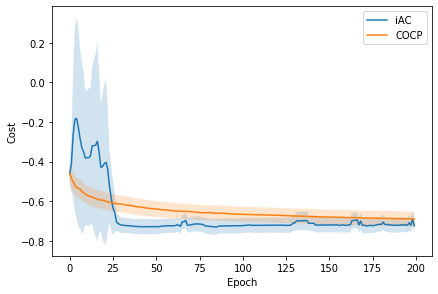

In [4]:
plt.plot(m_iAC, label="iAC")
plt.fill_between(m, (m_iAC - v_iAC), (m_iAC + v_iAC), alpha=0.2)

plt.plot(m_cocp, label="COCP")
plt.fill_between(m, (m_cocp - v_cocp), (m_cocp + v_cocp), alpha=0.2)
plt.tight_layout()

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

## Learning Rate - iAC

In [5]:
lr_1 = pd.read_csv("experiments/iAC_lr_0.01.csv")
lr_5 = pd.read_csv("experiments/iAC_lr_0.05.csv")
lr_75 = pd.read_csv("experiments/iAC_lr_0.075.csv")

lr_1 = lr_1.to_numpy()[:-1]
lr_5 = lr_5.to_numpy()[:-1]
lr_75 = lr_75.to_numpy()[:-1]

m = range(len(iAC))

In [6]:
m_lr1 = lr_1.mean(1)
m_lr5 = lr_5.mean(1)
m_lr75 = lr_75.mean(1)

v_lr1 = lr_1.var(1)
v_lr5 = lr_5.var(1)
v_lr75 = lr_75.var(1)

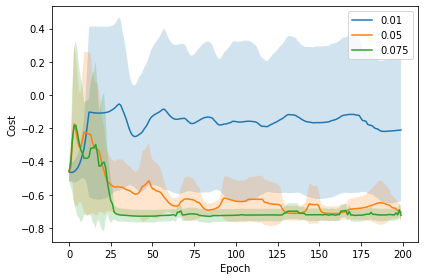

In [7]:
plt.plot(m_lr1, label="0.01")
plt.plot(m_lr5, label="0.05")
plt.plot(m_lr75, label="0.075")

plt.fill_between(m, (m_lr1 - v_lr1), (m_lr1 + v_lr1), alpha=0.2)
plt.fill_between(m, (m_lr5 - v_lr5), (m_lr5 + v_lr5), alpha=0.2)
plt.fill_between(m, (m_lr75 - v_lr75), (m_lr75 + v_lr75), alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.tight_layout()

plt.legend()

plt.show()

## Meta Episode - iAC

In [8]:
e1 = pd.read_csv("experiments/iAC_meta_episode_1.csv").to_numpy()[:-1]
e2 = pd.read_csv("experiments/iAC_meta_episode_2.csv").to_numpy()[:-1]
e5 = pd.read_csv("experiments/iAC_meta_episode_5.csv").to_numpy()[:-1]
e10 = pd.read_csv("experiments/iAC_meta_episode_10.csv").to_numpy()[:-1]

m_e1 = e1.mean(1)
m_e2 = e2.mean(1)
m_e5 = e5.mean(1)
m_e10 = e10.mean(1)

v_e1 = e1.var(1)
v_e2 = e2.var(1)
v_e5 = e5.var(1)
v_e10 = e10.var(1)

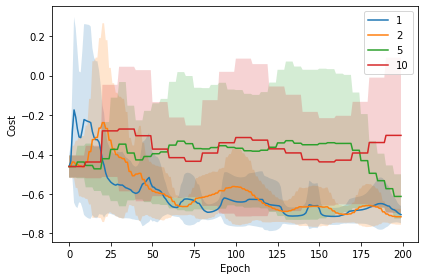

In [9]:
plt.plot(m_e1, label="1")
plt.plot(m_e2, label="2")
plt.plot(m_e5, label="5")
plt.plot(m_e10, label="10")

plt.fill_between(m, (m_e1 - v_e1), (m_e1 + v_e1), alpha=0.2)
plt.fill_between(m, (m_e2 - v_e2), (m_e2 + v_e2), alpha=0.2)
plt.fill_between(m, (m_e5 - v_e5), (m_e5 + v_e5), alpha=0.2)
plt.fill_between(m, (m_e10 - v_e10), (m_e10 + v_e10), alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.tight_layout()

plt.legend()

plt.show()

## Model mismatch

In [10]:
iAC = pd.read_csv("experiments/iAC_mismatch_0.2.csv")
cocp = pd.read_csv("experiments/COCP_mismatch_0.2.csv")

iAC = iAC.to_numpy()[:-1]
cocp = cocp.to_numpy()

m = range(len(iAC))

In [11]:
m_iAC = iAC.mean(1)
m_cocp = cocp.mean(1)

v_iAC = iAC.var(1)
v_cocp = cocp.var(1)

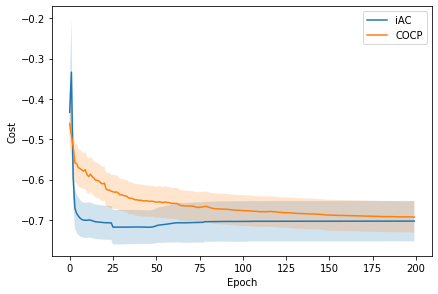

In [12]:
plt.plot(m_iAC, label="iAC")
plt.fill_between(m, (m_iAC - v_iAC), (m_iAC + v_iAC), alpha=0.2)

plt.plot(m_cocp, label="COCP")
plt.fill_between(m, (m_cocp - v_cocp), (m_cocp + v_cocp), alpha=0.2)
plt.tight_layout()

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()